In [3]:
import pandas as pd
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import torch
import torchvision
import torchvision.transforms as tt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from custom_loader import CustomLoader as CustomLoader

from tqdm import tqdm


In [ ]:
#Getting the base working directory
base = r'C:\Users\I N V A D E R\a__'
os.chdir(base)
os.getcwd()

In [3]:
#Looking at the content of mat file
car_annos = loadmat(base + '/Stanford Cars Dataset/annotations/cars_annos.mat')
car_annos

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
         ...,
         (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dt

# Data Preprocessing

In [4]:
#Total of 196 classes of cars 

label = [c for c in car_annos['class_names'][0]]
label = pd.DataFrame(label, columns = ['Model'])

print('{} classes '.format(len(label)))
label.head(196)

196 classes 


,Model
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
...,...
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007


In [5]:
#Using a dictionary to match the key value ie, class no. and model name
labels_dict = label.to_dict()['Model']
for key, value in labels_dict.items() :
    key = int(key)
    value = str(value)

In [6]:
labels_dict

{0: 'AM General Hummer SUV 2000',
 1: 'Acura RL Sedan 2012',
 2: 'Acura TL Sedan 2012',
 3: 'Acura TL Type-S 2008',
 4: 'Acura TSX Sedan 2012',
 5: 'Acura Integra Type R 2001',
 6: 'Acura ZDX Hatchback 2012',
 7: 'Aston Martin V8 Vantage Convertible 2012',
 8: 'Aston Martin V8 Vantage Coupe 2012',
 9: 'Aston Martin Virage Convertible 2012',
 10: 'Aston Martin Virage Coupe 2012',
 11: 'Audi RS 4 Convertible 2008',
 12: 'Audi A5 Coupe 2012',
 13: 'Audi TTS Coupe 2012',
 14: 'Audi R8 Coupe 2012',
 15: 'Audi V8 Sedan 1994',
 16: 'Audi 100 Sedan 1994',
 17: 'Audi 100 Wagon 1994',
 18: 'Audi TT Hatchback 2011',
 19: 'Audi S6 Sedan 2011',
 20: 'Audi S5 Convertible 2012',
 21: 'Audi S5 Coupe 2012',
 22: 'Audi S4 Sedan 2012',
 23: 'Audi S4 Sedan 2007',
 24: 'Audi TT RS Coupe 2012',
 25: 'BMW ActiveHybrid 5 Sedan 2012',
 26: 'BMW 1 Series Convertible 2012',
 27: 'BMW 1 Series Coupe 2012',
 28: 'BMW 3 Series Sedan 2012',
 29: 'BMW 3 Series Wagon 2012',
 30: 'BMW 6 Series Convertible 2007',
 31: '

In [7]:
list_label = list()
for something in car_annos['annotations'][0]:
    list_label.append((something[0].item()[-10:], something[-2].item()-1, something[-1].item()))

label_data_frame = pd.DataFrame(list_label)
label_data_frame.head(5)

,0,1,2
0,000001.jpg,0,0
1,000002.jpg,0,0
2,000003.jpg,0,0
3,000004.jpg,0,0
4,000005.jpg,0,0


In [8]:
car_annos['annotations'][0]

array([(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
       ...,
       (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8)),
       (array(['car_ims/016184.jpg'], dtype='<U18'), array([[56]], dtype=uint8), array([[60]],

In [9]:
#0 : train, 1: test
#From this, can verify that 8144 train, 8041 test

train_test_count = label_data_frame[2]
train_test_count.value_counts()

0    8144
1    8041
Name: 2, dtype: int64

In [10]:
#Show the whole output
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

#Find out which class has the most occurence, which is class 118
class_count_series = label_data_frame[1]
class_count = class_count_series.value_counts(sort = True)
class_count

118    136
78      97
160     96
166     95
143     93
      ... 
174     61
63      59
157     58
98      55
135     48
Name: 1, Length: 196, dtype: int64

In [11]:
label_data_frame['Model'] = label_data_frame[1].map(labels_dict)
most_frequent_class = class_count.index[0]
most_frequent_model = labels_dict[int(most_frequent_class)]

print(f"The most frequent class is {most_frequent_class} which is {most_frequent_model} model.")

The most frequent class is 118 which is GMC Savana Van 2012 model.


In [12]:

base = (r'C:\Users\I N V A D E R\a__')
#os.mkdir('train')
#os.mkdir('test')

In [ ]:
#current = os.chdir(base + '/Stanford Cars Dataset/car_ims')
current = os.chdir(base + '\Stanford Cars Dataset\car_ims')
print(os.getcwd())

In [14]:
current = os.listdir(os.getcwd())
index = 0

#Check for . extension and if id = 1 move to test
for images in current:
    if images[-4] == '.':
        image_test = int(label_data_frame.iloc[index, 2])
        if image_test == 1:
            new = 'test/' + images
            os.rename(images, new)
        else:
            new = 'train/'+images
            os.rename(images, new)
        index += 1
        

In [15]:
os.getcwd()
os.listdir()
print(len(os.listdir('train')))
print(len(os.listdir('test')))

8144
8041


In [17]:
data_dir = (base + '\Stanford Cars Dataset\car_ims')
train_dir = (data_dir + '\\train')
test_dir = (data_dir + '\\test')

#data_dir = (base + '/Stanford Cars Dataset/car_ims')
#train_dir = (data_dir + '/train')
#test_dir = (data_dir + '/test')

# Data Augmentation
- PyTorch

S. Mascarenhas and M. Agarwal, "A comparison between VGG16, VGG19 and ResNet50 architecture frameworks for Image Classification," 2021 International Conference on Disruptive Technologies for Multi-Disciplinary Research and Applications (CENTCON), Bengaluru, India, 2021, pp. 96-99

Gan, Z., Liang, P., Li, X., Sun, C., & Kang, B. (2017). Analysis of Deep Convolutional Neural Network Models for the Fine-Grained Classification of Vehicles. IEEE Transactions on Intelligent Transportation Systems, 18(7), 1669-1680. doi: 10.1109/TITS.2016.2616572

credit: Some codes inspired by other online sources

In [19]:
#Data is augmented and then normalized

train_aug = tt.Compose([tt.Resize((224, 224)),
                         tt.RandomRotation(20), # rotate -/+15 degrees
                         tt.RandomHorizontalFlip(),
                         tt.ToTensor(),
                         tt.RandomErasing(inplace=True),#regularization to prevent overfit
                         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

val_aug = tt.Compose([tt.Resize((224,224)), 
                         tt.ToTensor(), 
                         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 


In [20]:
# load data and apply the augmentation on it
train_ds = CustomLoader(label_data_frame, 
                            train_dir, 
                            transformation = train_aug, 
                            transform = True)

test_ds = CustomLoader(label_data_frame, 
                           test_dir, 
                           transformation = val_aug, 
                           transform=True)

In [21]:
# PyTorch data loaders
batch_size = 32

train_dataloader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3) 
val_dataloader = DataLoader(test_ds, batch_size, num_workers=3)

# Check for GPU
Move data to use GPU if cuda available

In [22]:
def default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [23]:
def to_device(tensorss, device):
    if isinstance(tensorss, (list, tuple)):
        return [to_device(x, device) for x in tensorss]
    return tensorss.to(device, non_blocking = True)

In [24]:
class DeviceDataloader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for batch in self.dl:
            yield to_device(batch, self.device)
        
    def __len__(self):
        return len(self.dl)

In [25]:
# Check available device type
device = default_device()
device

device(type='cuda')

In [26]:
train_dataloader = DeviceDataloader(train_dataloader, device)
val_dataloader = DeviceDataloader(val_dataloader, device)

# Using ResNet50

In [27]:
#Predefined functions
def accuracy(output, label):
    _, preds = torch.max(output, dim = 1)
    accuracy_percent = torch.tensor(torch.sum(preds == label).item() / len(preds))
    return accuracy_percent

In [28]:
#Predefined functions
def evaluate(model, val_dataloader):
    model.network.eval()
    output = [model.validation_step(batch) for batch in tqdm(val_dataloader)]
    epoch_loss = model.validation_epoch_end(output)
    return epoch_loss


In [29]:
#Predefined functions
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [30]:
#Predefined functions
def fit(epochs, model, train_loader, loss , val_loader, scheduler, 
                        optimizer = torch.optim.SGD,  weight_decay=0, grad_clip=None):
    torch.cuda.empty_cache()
    history = []
    model.train()

    for epoch in range(epochs):
        train_losses = []
        
        #Training Phase 
        model.train()
        
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            
            train_losses.append(loss)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            #Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
        #Validation phase
        model.eval()
    
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        
        model.epoch_end(epoch, result)
        history.append(result)
        
        model.train()
        scheduler.step(result['val_acc'])
    return history

In [31]:
class MultilabelImageClassificationBase(nn.Module):
    def __init__(self):
        super().__init__()

    def training_step(self, batch):
        images, targets = batch
        predictions = self(images)
        loss = F.cross_entropy(predictions, targets)
        return loss

    def validation_step(self, batch):
        images, targets = batch
        predictions = self(images)
        loss = F.cross_entropy(predictions, targets)
        acc = accuracy(predictions, targets)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        return {'val_loss': avg_loss.item(), 'val_acc': avg_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch}], train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


In [32]:
class Resnet50(MultilabelImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        #Load pretrained resnet50
        self.network = models.resnet50(pretrained=True)
        
        #Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 196)
    
    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(Resnet50(), device)

In [34]:
#Inital loss and acc before any training
history = evaluate(model, val_dataloader)
history

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.06it/s]


{'val_loss': 5.340793609619141, 'val_acc': 0.004588293842971325}

Smith, Leslie N. "A disciplined approach to neural network hyper-parameters: Part 1--learning rate, batch size, momentum, and weight decay." (2018)

In [35]:
epochs = 20
grad_clip = 0.1
weight_decay = 1e-4
lr = 0.01

# Set up one-cycle learning rate scheduler
optimizer = torch.optim.SGD(model.parameters(), lr= lr, momentum=0.9)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, mode='max', patience=3, threshold = 0.9)

loss_fn = nn.CrossEntropyLoss()

In [36]:
history = fit(epochs = epochs, model = model, train_loader = train_dataloader, loss = loss_fn , val_loader = val_dataloader, scheduler = sched,
                  optimizer = optimizer,  weight_decay= weight_decay, grad_clip=grad_clip)

100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.31it/s]


Epoch [0], train_loss: 4.3136, val_loss: 3.1189, val_acc: 0.2206


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:26<00:00,  9.44it/s]


Epoch [1], train_loss: 2.6819, val_loss: 2.5471, val_acc: 0.3612


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:39<00:00,  6.45it/s]


Epoch [2], train_loss: 1.9892, val_loss: 1.9238, val_acc: 0.4892


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.05it/s]


Epoch [3], train_loss: 1.6216, val_loss: 1.7720, val_acc: 0.5192


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.05it/s]


Epoch [4], train_loss: 1.3139, val_loss: 1.4482, val_acc: 0.6079


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.33it/s]


Epoch [5], train_loss: 1.1247, val_loss: 1.4944, val_acc: 0.6079


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.20it/s]


Epoch [6], train_loss: 0.9807, val_loss: 1.1997, val_acc: 0.6685


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.17it/s]


Epoch [7], train_loss: 0.5788, val_loss: 0.5196, val_acc: 0.8459


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.19it/s]


Epoch [8], train_loss: 0.4362, val_loss: 0.4810, val_acc: 0.8555


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.08it/s]


Epoch [9], train_loss: 0.3987, val_loss: 0.4672, val_acc: 0.8576


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:26<00:00,  9.35it/s]


Epoch [10], train_loss: 0.3676, val_loss: 0.4602, val_acc: 0.8599


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:29<00:00,  8.68it/s]


Epoch [11], train_loss: 0.3458, val_loss: 0.4482, val_acc: 0.8643


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.33it/s]


Epoch [12], train_loss: 0.3265, val_loss: 0.4425, val_acc: 0.8671


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.13it/s]


Epoch [13], train_loss: 0.3173, val_loss: 0.4407, val_acc: 0.8684


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.03it/s]


Epoch [14], train_loss: 0.3110, val_loss: 0.4465, val_acc: 0.8650


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.04it/s]


Epoch [15], train_loss: 0.3096, val_loss: 0.4423, val_acc: 0.8676


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.24it/s]


Epoch [16], train_loss: 0.3168, val_loss: 0.4437, val_acc: 0.8669


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:26<00:00,  9.35it/s]


Epoch [17], train_loss: 0.3115, val_loss: 0.4407, val_acc: 0.8653


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:26<00:00,  9.35it/s]


Epoch [18], train_loss: 0.3114, val_loss: 0.4417, val_acc: 0.8671


100%|████████████████████████████████████████████████████████████████████████████████| 252/252 [00:27<00:00,  9.28it/s]

Epoch [19], train_loss: 0.3294, val_loss: 0.4399, val_acc: 0.8675


# Plotting accuracy and loss

In [37]:
#Create fig and ax object to create,save plot instead of plt.
def plot_acc(history):
    fig, ax = plt.subplots()
    ax.plot([x['val_acc'] for x in history], '-bx') #color blue with x marker
    ax.set(xlabel='epoch', ylabel='score', title='Accuracy vs Epochs')
    fig.savefig(base + '\\acc_loss_result\\accuracy_vs_epochs.png')
    plt.show()

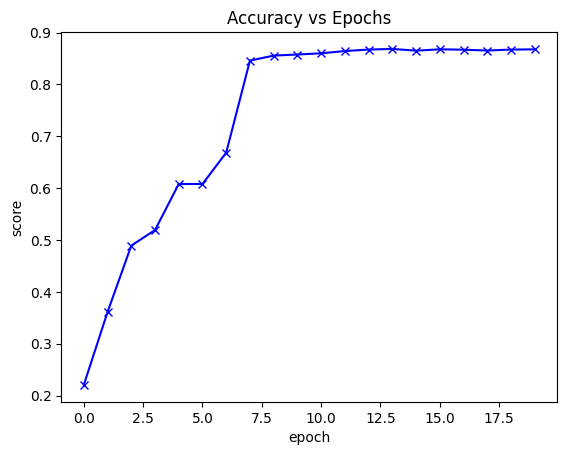

In [38]:
plot_acc(history)

In [39]:
def plot_losses(history):
    fig, ax = plt.subplots()
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    ax.plot(train_losses, '-gx') #color green with x marker
    ax.plot(val_losses, '-rx') #color red with x marker
    ax.set(xlabel='epoch', ylabel='loss', title='Loss vs Epochs')
    ax.legend(['Training', 'Validation'])
    fig.savefig(base + '\\acc_loss_result\\loss_vs_epochs.png')
    plt.show()


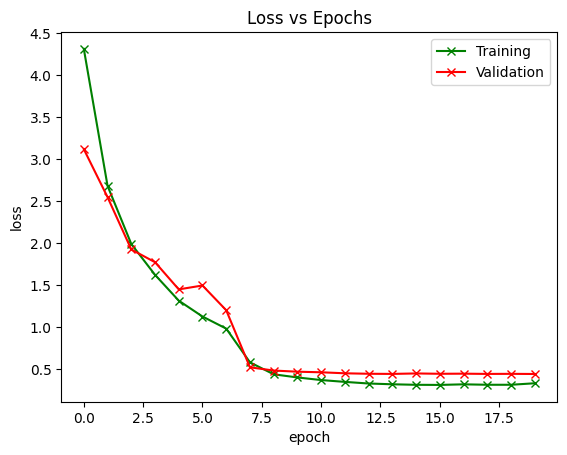

In [40]:
plot_losses(history)

# Predict


In [41]:
def predict_image(img):
    model.eval()
    
    label = labels_dict[img[1]]
    print(f"Actual: {label}") #real class
    
    with torch.no_grad(): #Speed up computation, by reduce memory usage
        x_tensor = img[0].unsqueeze(0).to(device)
        y_tensor = model(x_tensor)
        preds = y_tensor.argmax(dim=1) #highest probability index
        
    predicted_label = labels_dict[preds.item()]
    return predicted_label


In [42]:
def show_img(img):   
    img = torch.clamp(img, 0, 1)
    plt.imshow(img.permute(1, 2, 0)) #imshow needs H,W,C
    plt.show()

Actual: Acura TL Sedan 2012
Predicted: Acura TL Sedan 2012


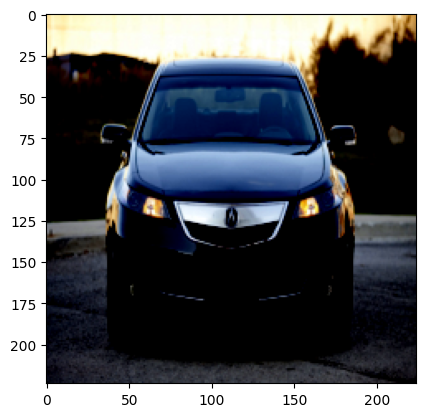

In [43]:
img = test_ds[87]
print('Predicted: {}'.format(predict_image(img)))
show_img(img[0])

Actual: Acura TSX Sedan 2012
Predicted: Acura RL Sedan 2012


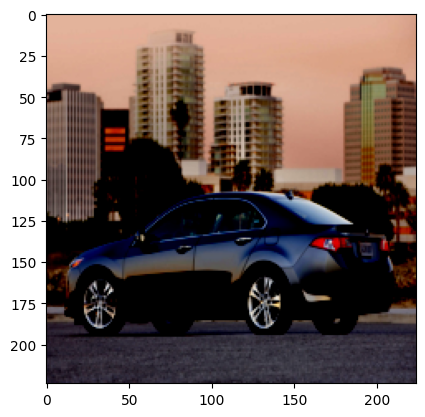

In [44]:
img = test_ds[187]
print('Predicted: {}'.format(predict_image(img)))
show_img(img[0])

Actual: Aston Martin V8 Vantage Convertible 2012
Predicted: BMW Z4 Convertible 2012


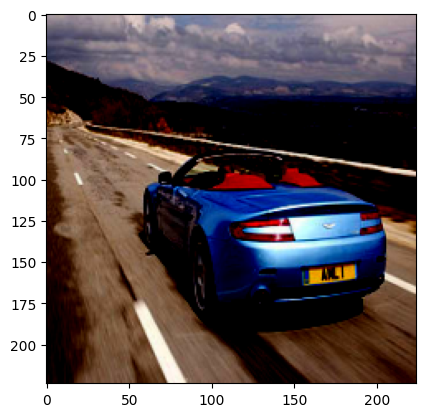

In [45]:
img = test_ds[287]
print('Predicted: {}'.format(predict_image(img)))
show_img(img[0])

Actual: Audi S5 Coupe 2012
Predicted: Audi S5 Coupe 2012


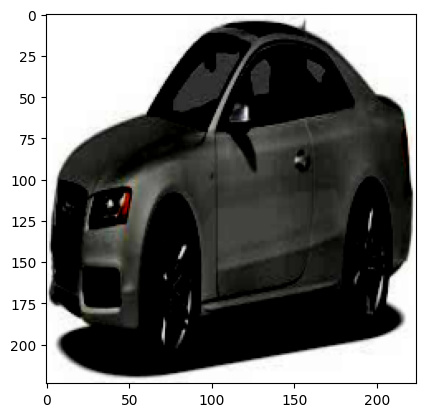

In [46]:
img = test_ds[887]
print('Predicted: {}'.format(predict_image(img)))
show_img(img[0])

## Saving model

In [47]:
os.chdir(base + '\\app\\model')

In [49]:
torch.save(model.state_dict(), 'car_H.pth')